In [1]:
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
import keras

In [85]:
def determine_imbalance(data):
    zero_class = data[data['Class']==0].count().iloc[-1]
    one_class = data[data['Class']==1].count().iloc[-1]
    return round((zero_class - one_class)/2)

In [3]:
# Assuming your GAN model is loaded and can generate synthetic data
def generate_synthetic_data(gan_model, num_samples, noise_dim):
    noise = np.random.normal(0, 1, (num_samples, noise_dim))
    synthetic_data = gan_model.predict(noise)
    return synthetic_data

In [97]:
def clip_negative_values(X, feature_indices):
    """ 
    Clip negative values to zero for the specified features.
    """
    X[:, feature_indices] = np.clip(X[:, feature_indices], a_min=50, a_max=None)
    return X

In [2]:
def concatenate_data(original_data, generated_data):
    return pd.concat([original_data, generated_data])

In [4]:
def separate_features_and_target(data, target_columns):
    X = data.drop(target_columns, axis=1)
    y = data[target_columns[-1]]
    return X, y

In [55]:
def standardize_features(X,reverse = False, scaler = None):
    if not reverse:
        scaler = StandardScaler()
        return scaler.fit_transform(X), scaler
    else:
        if scaler is None:
            raise ValueError("Scaler must be provided to inverse transform.")
        return scaler.inverse_transform(X)

In [6]:
def apply_smote(X, y, sampling_strategy='auto', random_state=42):
    smote = SMOTE(sampling_strategy=sampling_strategy, random_state=random_state)
    return smote.fit_resample(X, y)

In [7]:
def add_noise(X, noise_factor=0.01):
    noise = noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X.shape)
    return X + noise

In [8]:
def scale_features(X, scale_factor=0.02):
    scale = 1 + scale_factor * np.random.uniform(low=-1, high=1, size=X.shape)
    return X * scale


In [98]:
def data_augmentation_pipeline(data, target_columns, gan_model, noise_dim):
    # Step 0: Determine num_samples
    num_samples = determine_imbalance(data)
    print(f'Number of Samples: {num_samples}')
    
    # Step 1: Generate synthetic data using GAN
    generated_data = generate_synthetic_data(gan_model, num_samples, noise_dim)
    generated_data = clip_negative_values(generated_data,-1)
    generated_df = pd.DataFrame(generated_data, columns=data.columns[1:-1])
    generated_df[target_columns[-1]] = 1  # Assuming the GAN generates minority class (e.g., fraud)
    
    # Step 2: Concatenate original data with GAN-generated data
    combined_data = concatenate_data(data, generated_df)
    print(f'Data Shape: {data.shape}. Combined Data: {combined_data.shape}')
    
    # Step 3: Separate features and target
    X, y = separate_features_and_target(combined_data, target_columns)

    # Step 4: Standardize features
    X_scaled, scaler = standardize_features(X)
    print(f'Scaled X: {len(X_scaled)}')
    
    # Step 5: Apply SMOTE
    X_resampled, y_resampled = apply_smote(X_scaled, y)
    print(f'Smoted X: {len(X_resampled)}')
    
    # Step 6: Add random noise
    X_noisy = add_noise(X_resampled)
    print(f'Noisy X: {len(X_noisy)}')
    
    # Step 7: Apply scaling to features
    X_augmented = scale_features(X_noisy)

    X_rescaled = standardize_features(X_augmented,reverse = True,scaler = scaler)
    X_rescaled = clip_negative_values(X_rescaled, -1)
    # Step 8: Return augmented data as DataFrame
    augmented_data = pd.DataFrame(X_rescaled, columns=data.columns[1:-1])
    augmented_data[target_columns[-1]] = y_resampled
    
    return augmented_data


In [10]:
loaded_model = keras.saving.load_model("generator_model.keras")

In [11]:
data_path = '../data/imbalanced_90_10.csv'
data = pd.read_csv(data_path)

In [13]:
target_columns = ['id','Class']

In [14]:
noise_dim = 100

In [99]:
augmented_data = data_augmentation_pipeline(data, target_columns, loaded_model, noise_dim)

Number of Samples: 127942
3999/3999 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
Data Shape: (312747, 31). Combined Data: (440689, 31)
Scaled X: 440689
Smoted X: 568630
Noisy X: 568630


In [88]:
augmented_data.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,568630.000000,568630.000000,568630.000000,568630.000000,568630.000000,568630.000000,568630.000000,568630.000000,568630.000000,568630.000000,...,568630.000000,568630.000000,568630.000000,568630.000000,568630.000000,568630.000000,568630.000000,568630.000000,568630.000000,568630.0
mean,0.765514,0.025132,0.694418,-0.310575,0.662361,1.402755,0.650783,-0.427534,0.417290,1.460762,...,1.116578,-0.461297,0.081634,0.783735,-0.122245,0.680173,-0.476091,0.235533,7134.401729,0.5
std,1.138621,1.486302,2.597889,1.069104,1.084686,1.867139,0.876290,0.905661,0.773964,1.818452,...,1.694470,1.491874,1.353023,3.031336,1.484166,1.629556,1.198613,1.284005,7924.677245,0.5
min,-3.548387,-49.040347,-6.392546,-17.837174,-16.630339,-21.395683,-17.025053,-10.759574,-15.673249,-3.783153,...,-33.091206,-7.833485,-29.888511,-66.999757,-13.737251,-8.089248,-10.584511,-39.160396,0.000000,0.0
25%,-0.021225,-0.537913,-0.354078,-0.774889,0.051092,0.157378,0.313350,-0.879094,0.132917,0.450054,...,-0.129897,-1.456645,-0.377843,-0.477143,-0.906241,-0.364068,-1.362435,-0.167337,45.735232,0.0
50%,0.819775,-0.151162,0.330136,-0.153939,0.489540,0.901476,0.651074,-0.191946,0.400049,0.903868,...,0.058374,-0.406854,-0.080638,0.651141,-0.231301,0.442861,-0.310775,0.141138,3758.443889,0.5
75%,1.217795,0.775193,1.113425,0.357458,1.561948,2.387866,1.185810,-0.084717,0.715643,2.217177,...,2.908864,0.320618,0.174913,2.514923,0.483599,1.394575,-0.139908,0.968549,13858.081174,1.0
max,10.033824,4.417759,34.857143,3.149411,42.189638,25.866557,213.934257,14.562776,20.360825,32.078034,...,8.247510,25.049347,31.836159,13.134108,25.660972,9.604074,112.014286,78.433977,24456.073624,1.0


In [81]:
data.describe()

,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,312747.000000,312747.000000,312747.000000,312747.000000,312747.000000,312747.000000,312747.000000,312747.000000,312747.000000,312747.000000,...,312747.000000,312747.000000,312747.000000,312747.000000,312747.000000,312747.000000,312747.000000,312747.000000,312747.000000,312747.000000
mean,168251.785149,0.413886,-0.403402,0.558870,-0.602733,0.277877,0.356931,0.402826,-0.118551,0.480174,...,-0.089014,-0.011890,-0.007692,0.106526,-0.051234,-0.057970,-0.174852,-0.082824,12026.557985,0.090911
std,115894.801397,0.879767,0.785497,0.808094,0.792725,0.744031,0.799546,0.770504,0.480473,0.821775,...,0.503745,0.739356,0.712538,1.107867,0.871493,1.068159,0.629991,0.832973,6925.360993,0.287482
min,0.000000,-3.495584,-49.966572,-3.183760,-4.951222,-9.952786,-21.111108,-4.342687,-10.756342,-3.751900,...,-19.382523,-7.734798,-30.295450,-4.067968,-13.612633,-8.226969,-10.498633,-39.035243,50.120000,0.000000
25%,78354.500000,-0.188765,-0.636713,0.052019,-1.035293,-0.023665,-0.037094,0.222702,-0.198142,0.060523,...,-0.192643,-0.516894,-0.193529,-0.612379,-0.583395,-0.755677,-0.316073,-0.228559,6040.535000,0.000000
50%,156686.000000,0.133171,-0.392964,0.488180,-0.564674,0.213429,0.283614,0.426836,-0.143347,0.419006,...,-0.106103,-0.035278,-0.038526,0.101692,-0.047572,-0.089179,-0.228910,-0.066106,12000.800000,0.000000
75%,234942.500000,1.047262,-0.137461,1.040770,-0.193856,0.507522,0.667469,0.633306,-0.062485,0.842200,...,-0.012187,0.461416,0.131253,0.892100,0.505408,0.563791,-0.094767,0.123219,18033.975000,0.000000
max,568606.000000,2.229046,4.355071,14.125834,3.201536,42.716891,26.168402,217.873038,5.952470,20.270062,...,8.087080,12.632511,31.707627,12.965639,14.621509,5.623285,113.231093,77.255937,24039.930000,1.000000


In [38]:
zero = data[data['Class']==0].count().iloc[-1]

In [100]:
compare_df = augmented_data[augmented_data['Class'] == 1]

In [91]:
false_data = data[data['Class']==1]

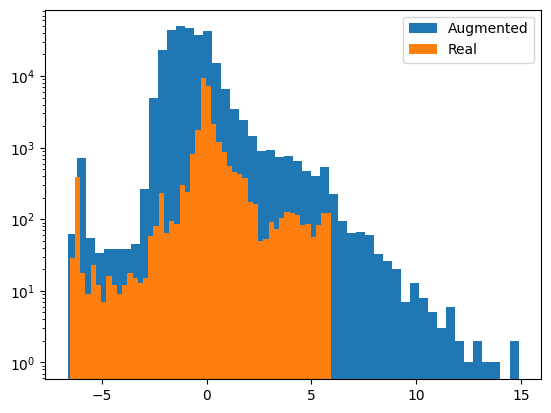

In [122]:
import matplotlib.pyplot as plt
plt.hist(compare_df['V8'],label='Augmented',bins = 50)
plt.hist(false_data['V8'],label='Real',bins = 50)
plt.legend()
plt.yscale('log')
#plt.xlim([1000,25000])